4주차 예습과제에서는 5주차 내용인 GPT의 생성 능력을 맛보고자 합니다. 사용할 모델은 koalpaca라는 모델인데, 한국어 버전의 alpaca 모델입니다.

alpaca는 llama라는 모델을 instruction fine-tuning 해서 사람의 지시를 잘 따르는 모델입니다.

llama라는 모델은 LLaMA-13B의 경우 GPT-3보다 10배이상 작음에도 불구하고 대부분의 평가서 GPT-3보다 우수한 성능을 보이며, 더 나아가 LLaMA-65B의 경우 대부분의 벤치마크에서 Chinchilla, Gopher, GPT-3, PaLM와 유사하거나 더 뛰어난 결과를 보이는 훌륭한 모델입니다.

그러면 지금부터 koalpaca로 생성 모델을 한번 경험해보도록 하겠습니다!

In [1]:
# GPU 켜져 있는지 확인

!nvidia-smi

Thu Feb  6 07:52:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) 

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

peft는 parameter efficient fine-tuning의 약자로, 큰 모델을 코랩에서 돌릴 수 있도록 쪼개서 만든 것입니다.

오래 걸립니다!

In [4]:
from peft import PeftModel, PeftConfig

In [5]:
# QLoRA 기법을 사용하여 사전 훈련된 KoAlpaca-Polyglot 12.8B 모델을 로드하고, 4비트 양자화를 적용하여 메모리 사용량을 줄이는 방식으로 실행하는 Python 코드

# Hugging Face에 업로드된 QLoRA 모델을 불러오기 위해 peft_model_id를 설정
# "beomi/qlora-koalpaca-polyglot-12.8b-50step"는 Beomi가 공개한 Polyglot 12.8B 모델을 50 스텝 동안 추가 학습한 모델
peft_model_id = "beomi/qlora-koalpaca-polyglot-12.8b-50step"

# PEFT (Parameter-Efficient Fine-Tuning) 설정
# PEFT는 미세 조정 시 모델 전체를 수정하지 않고 일부 가중치만 조정하는 방식
config = PeftConfig.from_pretrained(peft_model_id)

# NF4 (Normal Float 4) 방식은 GPTQ에서 자주 사용되는 4비트 양자화 기법
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4비트 양자화 적용
    bnb_4bit_use_double_quant=True, # 이중 양자화 사용 (추가적인 메모리 절약 가능)
    bnb_4bit_quant_type="nf4",  # NF4 (Normal Float 4) 양자화 방식 사용
    bnb_4bit_compute_dtype=torch.bfloat16   # 연산을 bfloat16 데이터 타입으로 수행
)

# 사전 훈련된 모델 로드
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, quantization_config=bnb_config, device_map={"":0})

# PEFT 모델 적용 (LoRA 어댑터 로드)
model = PeftModel.from_pretrained(model, peft_model_id)

# config.base_model_name_or_path에 해당하는 토크나이저를 불러오기
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# 모델을 평가 모드(inference 모드)로 설정하여 학습이 아니라 예측을 수행
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

model-00001-of-00028.safetensors:   0%|          | 0.00/946M [00:00<?, ?B/s]

model-00002-of-00028.safetensors:   0%|          | 0.00/843M [00:00<?, ?B/s]

model-00003-of-00028.safetensors:   0%|          | 0.00/843M [00:00<?, ?B/s]

model-00004-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00005-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00006-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00007-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00008-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00009-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00010-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00011-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00012-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00013-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00014-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00015-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00016-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00017-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00018-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00019-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00020-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00021-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00022-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00023-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00024-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00025-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00026-of-00028.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00027-of-00028.safetensors:   0%|          | 0.00/896M [00:00<?, ?B/s]

model-00028-of-00028.safetensors:   0%|          | 0.00/518M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/28 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/100 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(30080, 5120)
        (emb_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-39): 40 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_dropout): Dropout(p=0.0, inplace=False)
            (post_mlp_dropout): Dropout(p=0.0, inplace=False)
            (attention): GPTNeoXAttention(
              (query_key_value): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=15360, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8,

next token generation

In [6]:
# 미세 조정된 QLoRA 모델을 사용하여 자연어 생성을 수행

prompt = '인간처럼 생각하고, 행동하는 \'지능\'을 통해 인류가 이제까지 풀지 못했던'
with torch.no_grad():
  # 입력 문장을 토큰으로 변환 및 GPU 할당
  tokens = tokenizer.encode(prompt, return_tensors='pt').to(device='cuda', non_blocking=True)
  # 모델을 사용하여 텍스트 생성
  gen_tokens = model.generate(tokens, do_sample=True, temperature=0.8, max_length=64)
  # 생성된 토큰을 문자열로 변환
  generated = tokenizer.batch_decode(gen_tokens)[0]

print(generated)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


인간처럼 생각하고, 행동하는 '지능'을 통해 인류가 이제까지 풀지 못했던 문제들을 해결하는 데에 도움을 줄 것이다. 알파고의 다음 상대로는 스타크래프트의 가장 유명하면서도 난해한 맵인 '스타크래프트: 리마스터'를 지목


 QA

In [7]:
# QLoRA 기반 KoAlpaca-Polyglot 모델을 사용하여 질의응답을 수행하는 함수
def gen(x):
    q = f"### 질문: {x}\n\n### 답변:"
    # print(q)

    # 텍스트를 토큰화하여 모델에 입력
    gened = model.generate(
        **tokenizer(
            q,
            return_tensors='pt',
            return_token_type_ids=False
        ).to('cuda'),
        max_new_tokens=50,
        early_stopping=True,
        do_sample=True,
        eos_token_id=2,
    )
    print(tokenizer.decode(gened[0]))

In [8]:
gen('건강하게 살기 위한 세 가지 방법은?')

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:674: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### 질문: 건강하게 살기 위한 세 가지 방법은?

### 답변: 자신의 일을 가져라, 술과 담배를 끊어라, 규칙적인 생활을 해라인사청문회가 많은 이들의 주목을 끌고 있다. 고위관직에 오를 후보자들이 얼마나 청렴하고 도덕적 삶을


top_k와 같은 parameter를 조절하면서 실험해보세요!

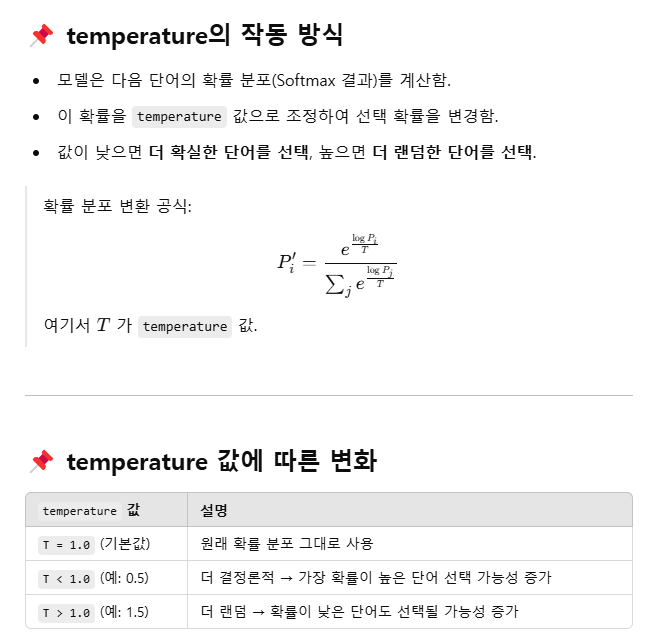

In [9]:
# top_k 파라미터는 텍스트 생성 시 모델이 고려할 후보 단어의 개수를 제한하는 기법
# 낮으면 보수적이고 일관된 답변, 높으면 창의적이고 예측 불가능한 답변을 생성

# temperature는 모델이 다음 단어를 선택할 때 확률 분포를 얼마나 부드럽게 만들지 조절하는 파라미터

prompt = '인간처럼 생각하고, 행동하는 \'지능\'을 통해 인류가 이제까지 풀지 못했던'
with torch.no_grad():
  tokens = tokenizer.encode(prompt, return_tensors='pt').to(device='cuda', non_blocking=True)
  gen_tokens = model.generate(tokens, do_sample=True, temperature=0.8, max_length=64, top_k=50)
  generated = tokenizer.batch_decode(gen_tokens)[0]

print(generated)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


인간처럼 생각하고, 행동하는 '지능'을 통해 인류가 이제까지 풀지 못했던 난제를 해결할 수 있을 것"이라고 밝혔습니다.​또한, "IBM은 더 높은 수준의 인공지능 연구를 위해, 학계와 업계 간의 협력을 강화하고자 한다"
